In [1]:
import os
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix, f1_score
from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
import numpy as np
from models import networks
from transformers import BertTokenizer, RobertaTokenizer, AutoTokenizer


d:\MMSERA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval(opt, checkpoint_path, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = getattr(networks, opt.model_type)(
                num_classes=opt.num_classes,
                num_attention_head=opt.num_attention_head,
                dropout=opt.dropout,
                text_encoder_type=opt.text_encoder_type,
                text_encoder_dim=opt.text_encoder_dim,
                text_unfreeze=opt.text_unfreeze,
                audio_encoder_type=opt.audio_encoder_type,
                audio_encoder_dim=opt.audio_encoder_dim,
                audio_unfreeze=opt.audio_unfreeze,
                audio_norm_type=opt.audio_norm_type,
                fusion_head_output_type=opt.fusion_head_output_type,
            )
    network.to(device)

    # Build dataset
    _, test_ds = build_train_test_dataset(
        opt.data_root,
        opt.batch_size,
        tokenizer,
        opt.audio_max_length,
        text_max_length=opt.text_max_length,
        audio_encoder_type=opt.audio_encoder_type,
    )
    # Load checkpoint with save_all_states = False
    # network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device)).state_dict())
    # Load checkpoint with save_all_states = True
    network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device))["state_dict_backbone"])
    network.eval()
    network.to(device)

    y_actu=[]
    y_pred=[]

    for every_test_list in tqdm(test_ds):
        input_ids, audio, label,am,ve = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        am = am.to(device)
        with torch.no_grad():
            output = network(input_ids,audio, attention_mask=am)[0]
            _, preds = torch.max(output, 1)
            y_actu.append(label.detach().cpu().numpy()[0])
            y_pred.append(preds.detach().cpu().numpy()[0])
    print(accuracy_score(y_actu, y_pred))
    wa = balanced_accuracy_score(y_actu, y_pred)
    ua = accuracy_score(y_actu, y_pred)
    print("Balanced Accuracy: ", wa)
    print("Accuracy: ", ua)
    cm = confusion_matrix(y_actu, y_pred)
    print(cm)
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
    print (cmn)

    f1 = f1_score(y_actu, y_pred, average='macro')
    print("F1: ", f1)
# Create a figure and axis
    fig, ax = plt.subplots()

# Create a heatmap
    cax = ax.matshow(cmn, cmap='Blues')

# Add color bar
    plt.colorbar(cax)

# Set labels for x and y axes
    plt.xlabel('Predicted')
    plt.ylabel('True')

# Set x and y axis ticks
    plt.xticks(np.arange(4), ["Happyniess", "Sadness", "Neutral", "Anger"])
    plt.yticks(np.arange(4), ["Happyniess", "Sadness", "Neutral", "Anger"])

    # plt.xticks(np.arange(6), ["Happyniess", "Sadness", "Neutral", "Anger", "excitement", "frustration"])
    # lt.yticks(np.arange(6), ["Happyniess", "Sadness", "Neutral", "Anger", "excitement", "frustration"])

# Display the values in each cell
    for i in range(4): #set choose number of classes
        for j in range(4):
            plt.text(j, i, format(cmn[i, j], '.2f'),
                 ha='center', va='center', color='black', fontsize=12)

# Show the plot
    plt.show()

100%|██████████| 1108/1108 [02:03<00:00,  8.96it/s]


0.6110108303249098
Balanced Accuracy:  0.6343042266486606
Accuracy:  0.6110108303249098
[[138  37  87  66]
 [ 14 165  31   7]
 [ 13  80 210  39]
 [ 13   6  38 164]]
[[42.07317073 11.2804878  26.52439024 20.12195122]
 [ 6.4516129  76.03686636 14.28571429  3.22580645]
 [ 3.80116959 23.39181287 61.40350877 11.40350877]
 [ 5.88235294  2.71493213 17.19457014 74.2081448 ]]
F1:  0.6130249973808893


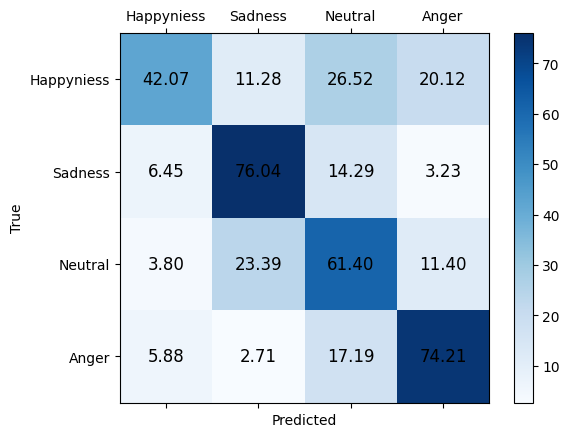

In [3]:
from configs.bert_vggish import Config as roberta_wav2vec2_config

#checkpoint_path = "G:/My Drive/checkpoints/IEMOCAP - Selfalign Bertbase" #check point
checkpoint_path = 'D:\MMSERA/notebooks\checkpoints/bert_vggish_MMSERA/20231128-194604'
opt_path = os.path.join(checkpoint_path,"opt.log").replace(os.sep, "/")
with open(opt_path, "r") as f:
    data = f.read().split("\n")
    # remove all empty strings
    data = list(filter(None, data))
    # convert to dict
    data_dict ={}
    for i in range(len(data)):
        key, value = data[i].split(":")[0].strip(), data[i].split(":")[1].strip()
        if '.' in value and value.replace('.', '').isdigit():
            value = float(value)
        elif value.isdigit():
            value = int(value)
        elif value == 'True':
            value = True
        elif value == 'False':
            value = False
        elif value == 'None':
            value = None
        data_dict[key] = value
# Load checkpoint with save_all_states = False
ckpt_path = os.path.join(checkpoint_path,"weights/best_acc/checkpoint_0_0.pt").replace(os.sep, "/")
#ckpt_path = os.path.join(checkpoint_path,"weights/best_loss/checkpoint_0_0.pt").replace(os.sep, "/")
#ckpt_path = os.path.join(checkpoint_path,"weights/checkpoint_32_128000.pt").replace(os.sep, "/")
# ckpt_path = 'D:/MMSERA/notebooks/checkpoints/bert_vggish_MMSERA/20231018-084650/weights/checkpoint_26_100000.pt'
opt = roberta_wav2vec2_config()
# Replace the default config with the loaded config
for key, value in data_dict.items():
    setattr(opt, key, value)
    
# Set dataset path
# opt.data_root="D:/dataset/IEMOCAP/IEMOCAP_full_release/IEMOCAP_data"
# opt.data_root="D:/MMSERA/notebooks/MELD_data/MELD"
opt.data_root = "D:/bert-based-selfalign/IEMOCAP_wav2vec/IEMOCAP_4_class"
# opt.data_root = "D:/iemocap_selfalign_updated/IEMOCAP/IEMOCAP_6_class"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
eval(opt, ckpt_path, tokenizer)